# Classification
## Objectives
* Fit and evaluate a classification model to predict if a prospect will churn or not.
## Inputs
* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.
## Outputs
* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot
---
## Change working directory
We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-market-analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-market-analysis'

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house-price-2021.csv")
      .drop(labels=['WoodDeckSF', 'EnclosedPorch'], axis=1)  
                    
  )

print(df.shape)
df.head()

(292, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1091,898.0,3.0,Mn,932,GLQ,133,586,Fin,2002.0,...,11367,90.0,210.0,60,5,8,1065,2002,2002,255000
1,988,517.0,3.0,No,399,Rec,484,240,Unf,1940.0,...,9144,66.0,0.0,0,5,5,883,1940,1982,145000
2,1040,0.0,3.0,Mn,532,LwQ,364,484,Unf,1977.0,...,8800,61.0,0.0,0,7,5,1040,1977,2008,150500
3,1572,1096.0,3.0,Av,1016,GLQ,556,726,Fin,2003.0,...,13688,110.0,664.0,0,5,9,1572,2003,2004,412500
4,2020,0.0,3.0,No,1436,GLQ,570,900,Fin,2009.0,...,12220,94.0,305.0,54,5,10,2006,2009,2009,402861


## Step 2: ML Pipeline with all data
### ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel
from feature_engine.selection import SmartCorrelatedSelection


def PipelineDataCleaningAndFeatureEngineering():

    df['BsmtExposure'] = df['BsmtExposure'].astype('category').cat.codes
    df['BsmtFinType1'] = df['BsmtFinType1'].astype('category').cat.codes
    df['GarageFinish'] = df['GarageFinish'].astype('category').cat.codes
    df['KitchenQual'] = df['KitchenQual'].astype('category').cat.codes

    
    # Combine preprocessing with feature selection
    pipeline_base = Pipeline([
        #("preprocessor", preprocessor),
        # ("StandardScaler", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor())),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                              method="pearson", threshold=0.9, selection_method="variance")),
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.9))])

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=101,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.shape)


(233, 21) (233,) (59, 21) (59,)
(233, 21)


In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train, y_train) 
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(233, 2) (233,) (59, 2) (59,)


### Handle Target Imbalance 

Check Train Set Target distribution

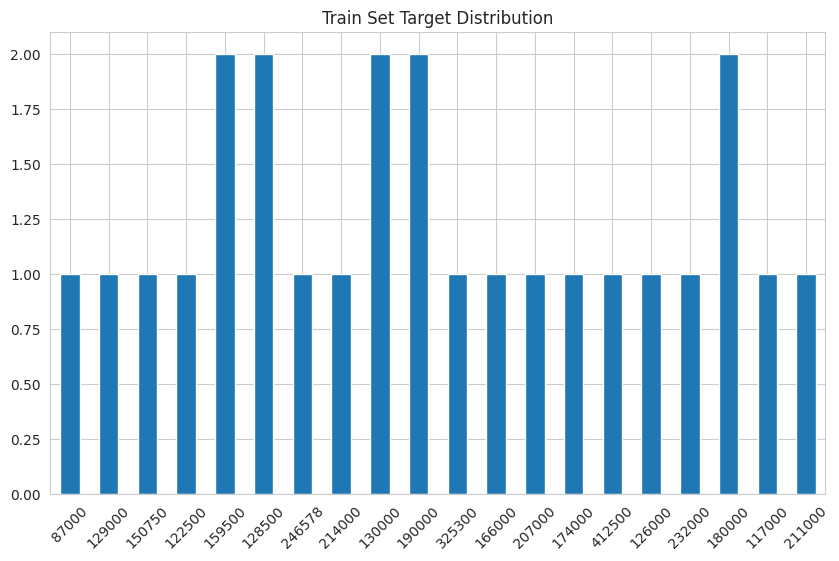

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed
np.random.seed(101)

sns.set_style("whitegrid")

#subsampled_counts = y_train.value_counts().sample(n=20)  # Adjust the sample size as needed
subsampled_counts = y_train.value_counts().sample(n=min(20, y_train.nunique()))
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = subsampled_counts.plot(kind='bar', title='Train Set Target Distribution')
ax.tick_params(axis='x', rotation=45)# Rotate x-axis labels
plt.show()


Use algorithms that handle class imbalance

In [11]:
from imblearn.under_sampling import NearMiss

# Define the NearMiss undersampler
undersampler = NearMiss(version=1, n_neighbors=1)

# Apply NearMiss undersampling to the dataset
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)


Check Train Set Target distribution after resampling

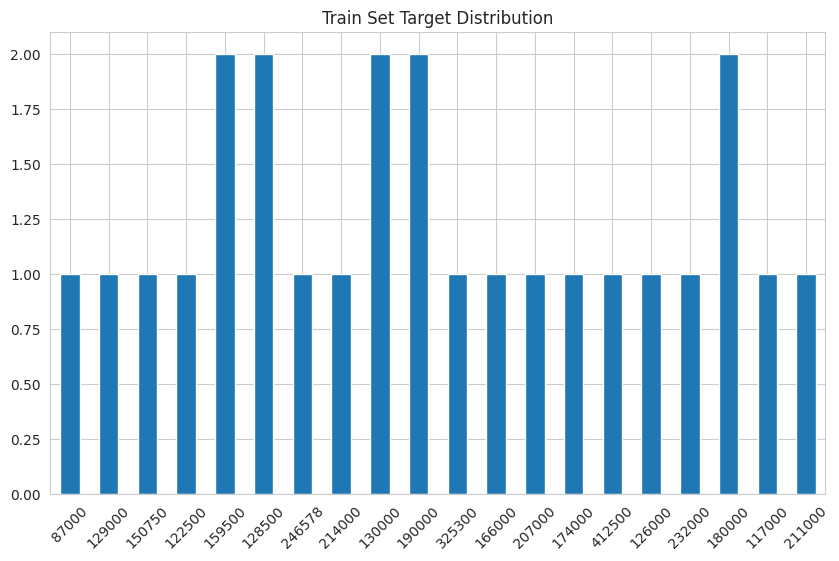

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set a random seed
np.random.seed(101)

sns.set_style("whitegrid")

#subsampled_counts = y_train.value_counts().sample(n=20)  # Adjust the sample size as needed
subsampled_counts = y_train.value_counts().sample(n=min(20, y_train.nunique()))
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = subsampled_counts.plot(kind='bar', title='Train Set Target Distribution')
ax.tick_params(axis='x', rotation=45)# Rotate x-axis labels
plt.show()

### Grid Search CV - Sklearn
#### Use standard hyperparameters to find most suitable algorithm

In [13]:
models_search = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(random_state=101),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=101),
    "RandomForestRegressor": RandomForestRegressor(random_state=101),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=101),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=101),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=101),#, algorithm='SAMME'
}

params_search = {
    "LinearRegression": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}


In [14]:
print(y_train.unique())


[197900 148500 179000  35311 174000 222000 177500 424870 134500 100000
 120000 110500 175000 116000  86000 155900 145000 165000 153500 135000
 121600 168500 132250 139000 114500 220000 200000  39300  87500 153900
 108000 219500 265979 176000 160000 212000 168000 230000 165150 109900
 102000 128950  79000 372500 213000 128500 112000 246578 110000 207000
 180500 117000 257000 137000 179200 223500 133000  90000 143000 236500
 311500 211000 124000 377426 150500 173000  89500 179900  97000 126000
 162900 105900 250000 392500  80500 152000 244000 147400 158000 157000
 128000 187500 239000 236000 131500 386250 119200 164500 166000 144000
 158500 142000 196500 190000 142953 248000 184000 130000 359100 175900
  95000 187000 104000  58500 130500 157500 164900 140000 148000 149500
  34900 142500 122500  93000 274000 325300 303477 114504 178000 135900
 225000 222500 319900 132500 475000 264561 136000 132000 214000  52500
 159000 314813 183500 412500 165400 252000 155000 232000 150750 197000
 14100

Quick GridSearch CV - Binary Classifier

In [15]:
from sklearn.metrics import make_scorer, r2_score

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,#_mapped,
           scoring =  make_scorer(r2_score, ),
           n_jobs=-1, cv=3)


Running GridSearchCV for LinearRegression 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for XGBRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.429533,0.558073,0.681176,0.102805
3,RandomForestRegressor,0.384394,0.545751,0.627515,0.1141
4,GradientBoostingRegressor,0.351044,0.493963,0.624599,0.112016
1,XGBRegressor,0.351009,0.493951,0.6246,0.112031
5,ExtraTreesRegressor,0.351009,0.493951,0.6246,0.112031
2,DecisionTreeRegressor,0.351009,0.493951,0.6246,0.112031
6,AdaBoostRegressor,0.27022,0.467857,0.629891,0.148978


#### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.
Define model and parameters, for Extensive Search

In [17]:
models_search = {
    "XGBRegressor": XGBRegressor(random_state=101),
}

# Documentation to help on hyperparameter list:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBRegressor": {
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 5, 10],
    }
}


Extensive GridSearch CV - Binary Classifier

In [18]:
from sklearn.metrics import r2_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, #_mapped
           scoring =  make_scorer(r2_score,),
           n_jobs=-1, cv=3)


Running GridSearchCV for XGBRegressor 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Check results

In [19]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
4,XGBRegressor,0.399666,0.497485,0.562295,0.070376,0.01,5
5,XGBRegressor,0.399666,0.497485,0.562295,0.070376,0.01,10
3,XGBRegressor,0.402119,0.494661,0.561954,0.067651,0.01,3
0,XGBRegressor,0.351736,0.494293,0.624582,0.111726,0.1,3
1,XGBRegressor,0.35159,0.494186,0.624581,0.111782,0.1,5
2,XGBRegressor,0.351575,0.494181,0.624581,0.111788,0.1,10
7,XGBRegressor,0.070151,0.099966,0.142622,0.030948,0.001,5
8,XGBRegressor,0.070151,0.099966,0.142622,0.030948,0.001,10
6,XGBRegressor,0.070156,0.098452,0.142622,0.031642,0.001,3


Get best model name programmatically

In [20]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBRegressor'

Parameters for best model

In [21]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01, 'model__max_depth': 5}

Define the best clf pipeline

In [22]:
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        grow_policy=None,
                                                        importance...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=101, ...))])

### Assess feature importance

In [23]:
#X_train.tail()
import pandas as pd

# Convert X_train to a pandas DataFrame
X_train_df = pd.DataFrame(X_train)

# Now use the .tail() method
X_train_df.tail()


,x0,x1
228,2295.0,7.0
229,816.0,4.0
230,1283.0,5.0
231,803.0,5.0
232,1375.0,6.0


* With the current model, we can assess with .features_importances_

* These are the 1 most important features in descending order. The model was trained on them: 
['x1']


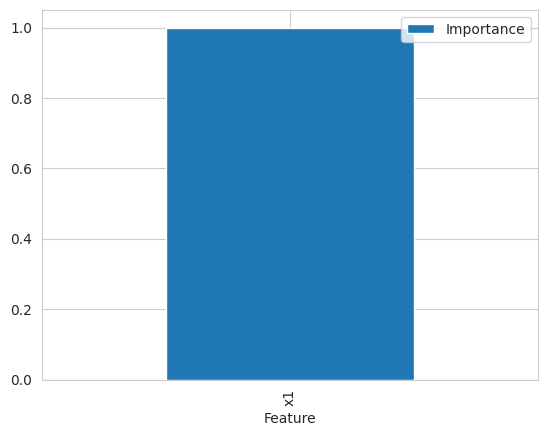

In [24]:
import pandas as pd

# Assuming X_train is your NumPy array
X_train_df = pd.DataFrame(X_train)

# Now you can access the columns attribute
columns = X_train_df.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns[pipeline_reg['feat_selection'].get_support()],
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [25]:
from sklearn.metrics import mean_squared_error, r2_score


def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    print("#### Train Set #### \n")
    y_train_pred = pipeline.predict(X_train)
    print("Mean Squared Error (Train):", mean_squared_error(y_train, y_train_pred))
    print("R2 Score (Train):", r2_score(y_train, y_train_pred))

    print("\n#### Test Set ####\n")
    y_test_pred = pipeline.predict(X_test)
    print("Mean Squared Error (Test):", mean_squared_error(y_test, y_test_pred))
    print("R2 Score (Test):", r2_score(y_test, y_test_pred))

    from sklearn.pipeline import Pipeline


In [26]:
from sklearn.pipeline import Pipeline

def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    # Print the pipeline steps and their parameters
    print("Pipeline steps:")
    for step_name, step_obj in pipeline.named_steps.items():
        print("Step:", step_name)
        print("Parameters:")
        print(step_obj)
        print()


---


In [27]:
import warnings

# Suppress undefined metric warnings
warnings.filterwarnings("ignore", category=UserWarning)


Evaluation: We cross check with metrics defined at ML business case

* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set.

In [28]:
reg_performance(X_train=X_train, y_train=y_train,
                 X_test=X_test, y_test=y_test,
                 pipeline=pipeline_reg,
                )

print(y_train)

Pipeline steps:
Step: scaler
Parameters:
StandardScaler()

Step: feat_selection
Parameters:
SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
               

## Step 3: Refit pipeline with best features
### Refit ML Pipeline and Resampling
In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().
### Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [29]:
best_features

['x1']

New Pipeline for DataCleaning And FeatureEngineering

In [30]:
from feature_engine.encoding import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


"""df['BsmtExposure'] = df['BsmtExposure'].astype('category').cat.codes
df['BsmtFinType1'] = df['BsmtFinType1'].astype('category').cat.codes
df['GarageFinish'] = df['GarageFinish'].astype('category').cat.codes
df['KitchenQual'] = df['KitchenQual'].astype('category').cat.codes
"""
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Add preprocessing steps suitable for numerical features

        #("SimpleImputer", SimpleImputer(strategy='median')),  # Handle missing values with median imputation
        ("Scaler", StandardScaler()),  # Scale numerical features
        #("preprocessor", preprocessor),
        ("feature_selection", SelectFromModel(RandomForestRegressor())),
    ])

    # You can add more steps here for additional numerical features if needed
    return pipeline_base



### Rewrite ML Pipeline for Modelling
Function for Pipeline optmisation

In [31]:
# Pipeline Optimization: Model
def PipelineReg(model):
    pipeline_base = Pipeline([
        #("preprocessor", PipelineDataCleaningAndFeatureEngineering()),
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

In [32]:
df.dtypes

1stFlrSF          int64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure       int8
BsmtFinSF1        int64
BsmtFinType1       int8
BsmtUnfSF         int64
GarageArea        int64
GarageFinish       int8
GarageYrBlt     float64
GrLivArea         int64
KitchenQual        int8
LotArea           int64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF       int64
OverallCond       int64
OverallQual       int64
TotalBsmtSF       int64
YearBuilt         int64
YearRemodAdd      int64
SalePrice         int64
dtype: object

### Split Train Test Set, considering only with best features

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

# Split the data into training and testing sets
X_train, y_train, y_train, y_test,  = train_test_split(
    X, y,
    test_size=0.2,
    random_state=101,
)

### Handle Target Imbalance

In [34]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()

X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train, y_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- x0
- x1
Feature names seen at fit time, yet now missing:
- 1stFlrSF
- 2ndFlrSF
- BedroomAbvGr
- BsmtExposure
- BsmtFinSF1
- ...


Check Train Set Target distribution

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

np.random.seed(101)

# Plot bar chart
counts = y_train.value_counts()
subsampled_counts = counts.sample(n=min(20, len(counts)))  # Subsample the counts

subsampled_counts.plot(kind='bar', title='Train Set Target Distribution')

# Set title and labels
plt.title('Train Set Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plot
plt.show()

Use NearMiss to balance Train Set target

In [ ]:
from imblearn.under_sampling import NearMiss

# Define the NearMiss undersampler
undersampler = NearMiss(version=1, n_neighbors=1)

# Apply NearMiss undersampling to the dataset
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

Check Train Set Target distribution after NearMiss

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

np.random.seed(101)

# Plot bar chart
counts = y_train.value_counts()
subsampled_counts = counts.sample(n=min(20, len(counts)))  # Subsample the counts

subsampled_counts.plot(kind='bar', title='Train Set Target Distribution')

# Set title and labels
plt.title('Train Set Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plot
plt.show()

### Grid Search CV: Sklearn
Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from the last GridCV search

In [ ]:
models_search   # XGBRegressor

And the best parameters from the last GridCV search

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {
    'XGBRegressor': {
        'model__learning_rate': [0.01],   # the value should be in []
        'model__max_depth': [3],  # the value should be in []
    }
}


GridSearch CV

In [ ]:
import pandas as pd 
from sklearn.metrics import make_scorer, r2_score

quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(r2_score, ),
                 n_jobs=-1, cv=3)

print(X_train.shape)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

Define the best clf pipeline

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_reg = grid_search_pipelines[best_model].best_estimator_
pipeline_reg

### Assess feature importance

In [ ]:
print("best_features:", best_features)
print("feature_importances:", pipeline_reg['model'].feature_importances_)
print("Length of best_features:", len(best_features))
print("Length of feature_importances:", len(pipeline_reg['model'].feature_importances_))


In [ ]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_reg['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets
Evaluation: We cross-check with metrics defined in the ML business case.

* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set.

In [ ]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_reg,
                )

# Step 4: Push files to Repo
We will generate the following files

* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set
* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
# X_train.head()

In [ ]:
import pandas as pd

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train)

# Save the DataFrame to a CSV file
X_train_df.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
X_train_df.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set
* note that the variables are transformed already in X_test

In [ ]:
import pandas as pd

# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)

# Now you can use DataFrame methods like head()
X_test_df.head()

In [ ]:
print(X_test_df.shape)
X_test_df.head()

In [ ]:
X_test_df.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline
We will save 2 pipelines:

* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.
Pipeline responsible for Data Cleaning and Feature Engineering.

In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_reg ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

### Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')